<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Ensembles and Random Forests - Practice
 
_Author: B Rhodes (DC)_

---

## Introduction

In this notebook, you'll build models using two tree-based ensemble models: bag of trees and random forest. 
We'll be working with a dataset to predict a salaries based on census data. 

### Objectives

You will be able to: 

- Use `scikit-learn` to train a random forest model.  
- Be able to determine the performance, of the model.
- Identify, visualize and interpret the important features from an ensemble model.


## Import data

Below we will use information derived from census data to predict whether someone makes more or less than $50k/year. Our goal is to determine which factors best predict an individual's salary.

Let's get our standard imports.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

The dataset is stored in the file `'salaries_census.csv'`.  

**Steps**: 
1. Import the dataset from the file above and store it in a DataFrame. The data file includes an index, so be sure to set the `index_col` parameter to `0`.  
2. Verify that everything loaded correctly.
3. Perform a little EDA.

In [2]:
# Import the data
path = '../data/salaries_census.csv'

# load the data into a dataframe 
salaries_df = pd.read_csv(path, index_col=0)
salaries_df.head()


,Age,Education,Occupation,Relationship,Race,Sex,Target
0,39,Bachelors,Adm-clerical,Not-in-family,White,Male,<=50K
1,50,Bachelors,Exec-managerial,Husband,White,Male,<=50K
2,38,HS-grad,Handlers-cleaners,Not-in-family,White,Male,<=50K
3,53,11th,Handlers-cleaners,Husband,Black,Male,<=50K
4,28,Bachelors,Prof-specialty,Wife,Black,Female,<=50K


### **Task**: Perform some EDA

In [3]:
salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Age           32561 non-null  int64 
 1   Education     32561 non-null  object
 2   Occupation    32561 non-null  object
 3   Relationship  32561 non-null  object
 4   Race          32561 non-null  object
 5   Sex           32561 non-null  object
 6   Target        32561 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.0+ MB


We have six (6) features and one (1) independent variable:

- `Age`: continuous 

- `Education`: Categorical. Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool 

- `Occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces 

- `Relationship`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried 

- `Race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black 

- `Sex`: Female, Male 

- `Target`: `<= 50k` and `>50k`. Use `.map()` this to `<= 50k`:0 and `>50k`:1.

In [4]:
## map the target categories to 0 & 1
salaries_df['Target'] = salaries_df['Target'].map({'<=50K':0, '>50K':1})


**Task**: Assign feature and target variables. Easiest way is to assign the `'Target'` column to a variable and then drop it from the dataset and assign the rest to another variable.

*Hint*: Use conventional variable names for features and target.

In [5]:
# Assign the feature and target variables

X = salaries_df.drop('Target', axis=1)
y = salaries_df['Target']

In the cell below, examine the data type of each column:  

In [6]:
# Your code here
X.dtypes

Age              int64
Education       object
Occupation      object
Relationship    object
Race            object
Sex             object
dtype: object

In [7]:
y.value_counts()

0    24720
1     7841
Name: Target, dtype: int64

**Task**: Create dummy variables to deal with the categorical features. Check the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) to recall how to do this.  

In [8]:
# Create dummy variables
X = pd.get_dummies(X, drop_first=True)
X.head(2)

,Age,Education_11th,Education_12th,Education_1st-4th,Education_5th-6th,Education_7th-8th,Education_9th,Education_Assoc-acdm,Education_Assoc-voc,Education_Bachelors,...,Relationship_Not-in-family,Relationship_Other-relative,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Male
0,39,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,1
1,50,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1


Perform a train/test split with a 75/25 split. Set the `random_state` to 42.  

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=123)

## Build a Decision Tree for Comparison

We'll begin by fitting a decision tree classifier (single tree) to provide a baseline and have something to compare to the ensemble methods.  

### Build the tree

**Task**: Instantiate and fit a decision tree classifier with the following parameters `criterion='gini'` and `max_depth=5`.

In [10]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5)

tree_clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

### Feature Importance

Let's explore the importance each feature used in our decision tree model. The trained classifier has an attribute `feature_importances_` that shows the relative importance of each feature. Display a sorted list of tuples in the form (feature, feature importance). *Hint*: use `zip()`.

In [11]:
# Feature importance
importances = list(tree_clf.feature_importances_)
features = list(X.columns)
important_features = list(zip(features, importances))

sorted(important_features,key=lambda x: x[1], reverse=True)

[('Age', 0.3044691779042325),
 ('Sex_Male', 0.15438616692649587),
 ('Relationship_Wife', 0.13774195284245822),
 ('Occupation_Prof-specialty', 0.1301960369130796),
 ('Occupation_Exec-managerial', 0.10865096080698204),
 ('Relationship_Not-in-family', 0.10188484915797898),
 ('Education_HS-grad', 0.017702307251322276),
 ('Education_Masters', 0.013623884955048345),
 ('Education_Bachelors', 0.01174726221918818),
 ('Occupation_Other-service', 0.01126856379111331),
 ('Education_Doctorate', 0.007313823685612183),
 ('Relationship_Own-child', 0.0005600418450383244),
 ('Race_Asian-Pac-Islander', 0.0004549717014502356),
 ('Education_11th', 0.0),
 ('Education_12th', 0.0),
 ('Education_1st-4th', 0.0),
 ('Education_5th-6th', 0.0),
 ('Education_7th-8th', 0.0),
 ('Education_9th', 0.0),
 ('Education_Assoc-acdm', 0.0),
 ('Education_Assoc-voc', 0.0),
 ('Education_Preschool', 0.0),
 ('Education_Prof-school', 0.0),
 ('Education_Some-college', 0.0),
 ('Occupation_Adm-clerical', 0.0),
 ('Occupation_Armed-Force

**Use the function below to visualize the data feature importances.**

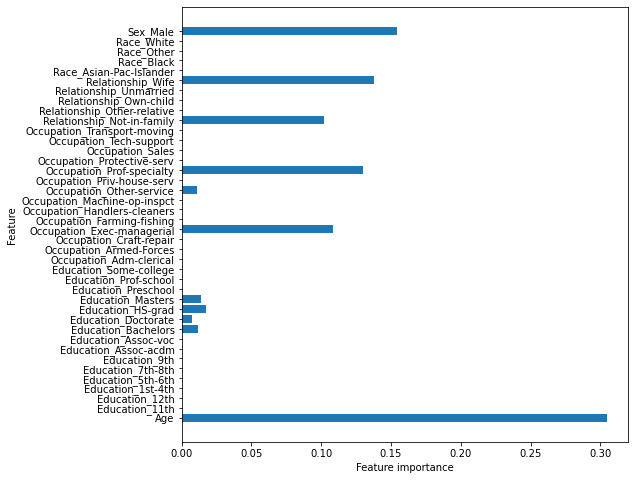

In [12]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

### Model performance

Check the model performance on the test data. We'll use the standard metrics.


* Use the model to generate predictions on the test set  
* Print out a `confusion_matrix` of the test set predictions 
* Print out a `classification_report` of the test set predictions 

In [13]:
# Test set predictions
y_pred = tree_clf.predict(X_test)


In [14]:
# Calculate Accuracy , AUC and Confusion matrix 
accuracy = accuracy_score(y_test, y_pred)

# get roc auc info
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

#print("Accuracy is : "+ str(round(accuracy,3)*100)+"%")
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, y_pred) * 100))
print("AUC is : "+str(round(roc_auc,3)))

# confusion matrix
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print('Classification Report:')
print(classification_report(y_test, y_pred))

Testing Accuracy for Decision Tree Classifier: 81.07%
AUC is : 0.669

Confusion Matrix:
[[5825  340]
 [1201  775]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      6165
           1       0.70      0.39      0.50      1976

    accuracy                           0.81      8141
   macro avg       0.76      0.67      0.69      8141
weighted avg       0.80      0.81      0.79      8141



## Ensemble Method #1: Bagged Trees

Use the bagging method (aka bag of trees) for our first ensemble method. 

**Tasks**:
1. Instantiate and fit a BaggingClassifier ([check the documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)).  
    1. Set the estimator to  a `DecisionTreeClassifier` with the same values from above for `criterion` and `max_depth`.  
    2. Also set the `n_estimators` parameter for our `BaggingClassifier` to `20`. 

In [15]:
# Instantiate a BaggingClassifier
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

# Fit to the training data
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

**Task**: Use the `.score()` method to check the accuracy of the model on the training data. 

In [16]:
# Training accuracy score

bag_score_train = bagged_tree.score(X_train, y_train)
print("Training Accuracy for Bagging Classifier: {:.4}%".format(bag_score_train * 100))


Training Accuracy for Bagging Classifier: 81.72%


**Task**: Use the `.score()` method to check the accuracy of the model on the testing data. 

In [17]:
# Test accuracy score
bag_score_test = bagged_tree.score(X_test, y_test)
print("Testing Accuracy for Bagging Classifier: {:.4}%".format(bag_score_test * 100))



Testing Accuracy for Bagging Classifier: 81.27%


## Random forests

The next ensemble method to demonstrate here is **_Random Forest_**. Following the standard approach set up a random forest classifier and see how it compares. 

### Fit a random forests model

In the cell below, instantiate and fit a `RandomForestClassifier`, and set the number estimators to `100` and the max depth to `5`. Then, fit the model to our training data. 

In [18]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=20, max_depth=5)

forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=20)

Now, let's check the training and testing accuracy of the model using its `.score()` method: 

In [19]:
# Training accuracy score
rf_score_train = forest.score(X_train, y_train)
print("Training Accuracy for Random Forest Classifier: {:.4}%".format(rf_score_train * 100))

Training Accuracy for Random Forest Classifier: 78.39%


In [20]:
# Test accuracy score
rf_score_test = forest.score(X_train, y_train)
print("Test Accuracy for Random Forest Classifier: {:.4}%".format(rf_score_test * 100))

Test Accuracy for Random Forest Classifier: 78.39%


### Feature importance

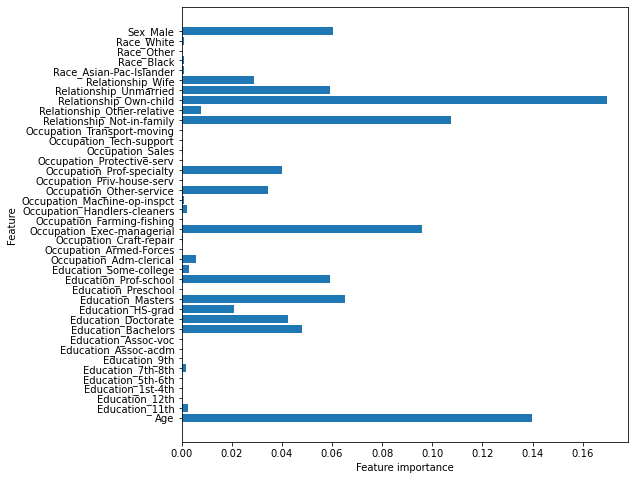

In [21]:
plot_feature_importances(forest)

What can you conclude about the feature importances above?
Also note that more features show up. This is a pretty typical result. 

### Inspect the Trees in the Forest
Let's create a forest with some small trees. You'll learn how to access trees in your forest!

In the cell below, create another `RandomForestClassifier`.  Set the number of estimators to 5, the `max_features` to 10, and the `max_depth` to 2.

In [22]:
# Instantiate and fit a RandomForestClassifier
forest_2 = RandomForestClassifier(n_estimators=5, max_features=10, max_depth=2)

forest_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=10, n_estimators=5)

Changing `max_features` to smaller values will generate to different trees in your forest! The trees in your forest are stored in the `.estimators_` attribute.

In the cell below, get the first tree from `forest_2.estimators_` and store it in `rf_tree_1`

In [23]:
forest_2.estimators_

[DecisionTreeClassifier(max_depth=2, max_features=10, random_state=2034131043),
 DecisionTreeClassifier(max_depth=2, max_features=10, random_state=1284876248),
 DecisionTreeClassifier(max_depth=2, max_features=10, random_state=1292401841),
 DecisionTreeClassifier(max_depth=2, max_features=10, random_state=1982038771),
 DecisionTreeClassifier(max_depth=2, max_features=10, random_state=87950109)]

In [24]:
# First tree from forest_2
rf_tree_1 = forest_2.estimators_[0]
rf_tree_1

DecisionTreeClassifier(max_depth=2, max_features=10, random_state=2034131043)

Use the `plot_feature_importances()` function to visualize which features this tree was given to use during subspace sampling. 

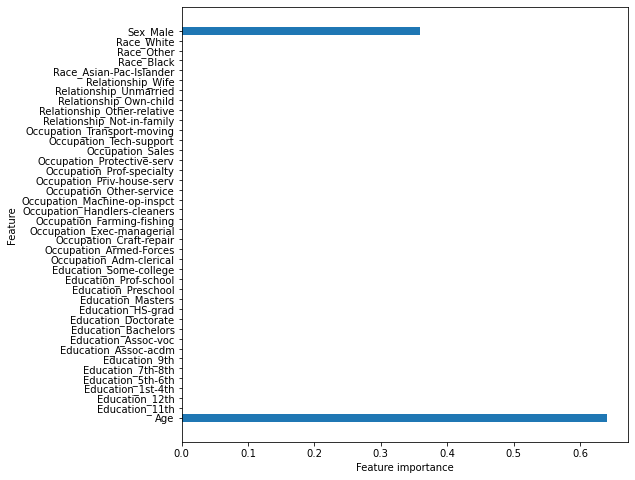

In [25]:
# Feature importance
plot_feature_importances(rf_tree_1)

Assign the second tree to `rf_tree_2`, and visualize it using `plot_feature_importances()`. 

In [26]:
# Second tree from forest_2
rf_tree_2 = forest_2.estimators_[1]

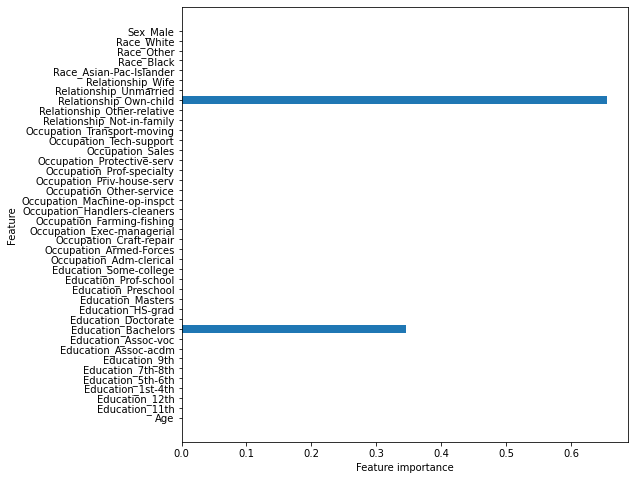

In [27]:
# Feature importance
plot_feature_importances(rf_tree_2)

**Question**: What can you conclude about these two trees and what can you say about how random forests work?

## Summary

Above, we built a few different tree ensemble methods. We demonstrated how to visualize and interpret feature importances, as well as compare individual trees from a random forest to see if we could notice the differences in the features they were trained on. 